# Introduction

## Imports

In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np
import matplotlib as mp
from matplotlib import pyplot as plt
from PIL import Image
import random

import cv2   # object detection
import tensorflow as tf  # deeplearning library
from tensorflow import keras
from keras import applications
from keras.models import load_model

from sklearn.model_selection import train_test_split  # splitting my nn data easily
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder



import sys
import os
print(os.listdir("../input"))
print(os.listdir("../input/natural_images"))


from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO

sys.path.append("..")


['data', '42780_75676_bundle_archive.zip', 'natural_images', 'weights.index', 'checkpoint', 'weights.data-00000-of-00001', 'model', 'single_picture', '.ipynb_checkpoints']
['motorbike', 'airplane', 'cat', 'car', 'person', 'flower', 'fruit', 'dog']


In [17]:
#from imageai.Detection import ObjectDetection
print(tf.__version__)

2.2.0


# Installs

## Env Setup

In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Global Vars

In [19]:
inp_img_width  = 224 #200
inp_img_height = 224 #100
img_size = inp_img_height * inp_img_width

## Define the Image-Sets

In [20]:
def load_images(image_dir):
    """Loads all images inside the imageDir into an array."""
    image_bond = [] # array for all images  
    image_path_list = []
    VALID_IMAGE_EXTENSIONS = [".jpg", ".jpeg", ".png"] # valid extensions

    for file in os.listdir(image_dir):
        extension = os.path.splitext(file)[1]
        if extension.lower() not in VALID_IMAGE_EXTENSIONS:
            continue
        image_path_list.append(os.path.join(image_dir, file))
        
    for imagePath in image_path_list:       
        img = cv2.imread(imagePath)  # reads all the images from the given path
        if img is None: # choose next
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_bond.append(img)
        
    return(image_bond)


def resize_images(img_arr, width, height):
    """Resizes a single image""" 
    img_res_arr = []
    width = width
    height = height
    
    for img in img_arr:
        img = cv2.resize(img,(width, height))
        img_res_arr.append(img)
    
    return img_res_arr

def gray_images(img_arr):
    img_arr_gray = []
    for img in img_arr:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_arr_gray.append(img)
    return img_arr_gray

def assign_images(img_arr,assignment):
    #img_arr_assigned = []
    #assignment_arr = [assignment]
    img_arr_assigned = [assignment for img in img_arr]
    #for img in img_arr:
    #    img_arr_assigned.append(assignment)
    return img_arr_assigned

The following part will load, resize and gray the image for the neural network. Because there are no predefined targets for the images I need to create them by myself based on the image foldername.

In [21]:
## Load images, resize and gray them and at least assign the correct object type

## Airplanes
images_airplanes = load_images('../input/natural_images/airplane/')          ## Load image into array of arrays
images_airplanes = resize_images(images_airplanes, inp_img_width,inp_img_height)  ## Resize the image to the predefined size
#images_airplanes = gray_images(images_airplanes)                                  ## Gray images 
images_airplanes_assigned = assign_images(images_airplanes,'airplane')            ## Assign the correct object to the image (our target)

## Motorbike
images_motorbikes = load_images('../input/natural_images/motorbike/')
images_motorbikes = resize_images(images_motorbikes, inp_img_width,inp_img_height)
#images_motorbikes = gray_images(images_motorbikes)
images_motorbikes_assigned = assign_images(images_motorbikes,'motorbike')

# Cars
images_cars      = load_images('../input/natural_images/car/')
images_cars      = resize_images(images_cars, inp_img_width,inp_img_height)
#images_cars      = gray_images(images_cars)
images_cars_assigned = assign_images(images_cars,'car')

# Cats
images_cats       = load_images('../input/natural_images/cat/')
images_cats       = resize_images(images_cats, inp_img_width,inp_img_height)
#images_cats       = gray_images(images_cats)
images_cats_assigned = assign_images(images_cats,'cat')

# Persons
images_persons    = load_images('../input/natural_images/person/')
images_persons    = resize_images(images_persons, inp_img_width,inp_img_height)
#images_persons    = gray_images(images_persons)
images_persons_assigned = assign_images(images_persons,'person')

Next step will be the combination of all the lists above into two lists:

* features and
* targets

#### Features

In [22]:
images_features = images_airplanes + images_motorbikes + images_cars + images_cats + images_persons
print('lenght of feature set: ',len(images_features))

lenght of feature set:  4354


#### Targets

In [23]:
images_targets = images_airplanes_assigned + images_motorbikes_assigned + images_cars_assigned + images_cats_assigned + images_persons_assigned
print('lenght of target set: ',len(images_targets))

lenght of target set:  4354


### Random Shuffle of the two Lists
I will use here a random shuffle for this two lists in a combined way to make sure all targets fit to their features and vice versa. It would be easier to hold both values (array-list based features and the targets) in one list instead of in two ones, but according to the array-list based features, it was difficult for me to find a good version that did not provoke the performances of this notebook. If you have any suggestions, please let me know in the comments.

In [24]:
# combine them in one list
comb_list = list(zip(images_features, images_targets))

random.seed(45)

# shuffle both list equaly
random.shuffle(comb_list)

# splitt them again
images_features, images_targets = zip(*comb_list)

Here the test now that feature (image) and target (typ) map.

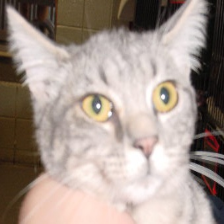

'cat'

In [25]:
from IPython.display import display

display(Image.fromarray(images_features[0]))
display(images_targets[0])

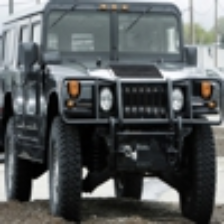

'car'

In [26]:
display(Image.fromarray(images_features[1]))
display(images_targets[1])

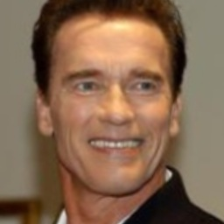

'person'

In [27]:
display(Image.fromarray(images_features[10]))
display(images_targets[10])

# The Model

## Preparing Training
In this chapter I will prepare the training set which will be a training set from different images of vehicles, persons and animals.

In [28]:
# splitting features and targets into train- and test- set
X_train, X_test, y_train, y_test = train_test_split(images_features, images_targets, test_size = 0.20, random_state = 45)

#### Features

In [29]:
# scaling, normalizing the image pixels (between 0 and 1)
X_train = tf.keras.utils.normalize(np.asfarray(X_train))#, axis = -1) 
X_test = tf.keras.utils.normalize(np.asfarray(X_test))#, axis = -1)

In [30]:
#X_train = np.asfarray(X_train)
#X_test = np.asfarray(X_test)

#### Targets

In [31]:
# join train and test to encode(get_dummies) all categories in the same way 
y = y_train + y_test
df_y = pd.DataFrame(y) 

In [32]:
# Label encoding of the targets
le = LabelEncoder()
le.fit(df_y)
df_y_hot = le.transform(df_y)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [33]:
# reshaping for the neural network
df_y_hot = pd.DataFrame(df_y_hot)
df_y_hot = np.asfarray(df_y_hot)

In [34]:
# write the created dummies back again
# just to make this clear: I used the length of the train data set to split the combined lists into train ([:len(y_train)]) and test([len(y_train):]) again.
#  in the same way I convert the result into in array, which is necessary for the use of an nn.
y_train = np.asfarray( df_y_hot[:len(y_train)] )#.reshape(1,-5)
y_test = np.asfarray( df_y_hot[len(y_train):] )#.reshape(1,-5)

## Model Building with Transfer Learning on ResNet50

In [35]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer


In [36]:
# Dataframes with all targets
df_y = pd.DataFrame(y)

In [37]:
# Drop all duplicates to just get the unique target values
df_y = df_y.drop_duplicates(subset = [0])
df_y

,0
0,person
1,airplane
2,motorbike
5,cat
6,car


In [38]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape = (inp_img_width, inp_img_height,3) )

In [39]:
## Github Pull: https://github.com/keras-team/keras/pull/9965

## From: https://keras.io/api/layers/normalization_layers/batch_normalization/
# Batch normalization applies a transformation 
# that maintains the mean output close to 0 and the output standard deviation close to 1.
for layer in resnet.layers:
    if isinstance(layer, tf.python.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [40]:
#for layer in resnet.layers:
#    layer.trainable = False

resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [41]:
model = tf.keras.models.Sequential()

In [42]:
model.add(resnet)

### Abschluss

In [43]:
model.add(tf.keras.layers.Flatten())

In [44]:
# Fully connected layer with 5 neurons (our final prediction classes)
model.add(Dense(5, activation="softmax"))

In [45]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )


In [46]:
print("Number of weights after calling the model:", len(model.weights))

Number of weights after calling the model: 320


In [47]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 501765    
Total params: 24,089,477
Trainable params: 554,885
Non-trainable params: 23,534,592
_________________________________________________________________


In [48]:
model.fit(X_train, 
          y_train,
          steps_per_epoch=3483, # X_train.shape[1]
          epochs = 3
         )



Epoch 1/3
3483/3483 [==============================] - 649s 186ms/step - loss: 2.7279 - accuracy: 0.9139
Epoch 2/3
3483/3483 [==============================] - 636s 183ms/step - loss: 1.0463 - accuracy: 0.9779
Epoch 3/3
3483/3483 [==============================] - 631s 181ms/step - loss: 0.8003 - accuracy: 0.9845


In [49]:
weights_path = "../output/weights"

model.save_weights('../output/weights')

In [50]:
model.save('../output/model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../output/model/assets


## Model Load

In [51]:
# Create new model based on original one
new_model = tf.keras.models.load_model('../output/model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 501765    
Total params: 24,089,477
Trainable params: 24,036,357
Non-trainable params: 53,120
_________________________________________________________________


In [52]:
# Loads the weights
new_model.load_weights('../output/weights')

In [53]:
# Re-evaluate the model
loss, acc = new_model.evaluate(X_test,  y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

28/28 - 18s - loss: 3.1952 - accuracy: 0.9403
Restored model, accuracy: 94.03%


## Test with totaly unknown Image

In [54]:
# laoding and resizing the image
single_image = load_images('../input/single_picture/')          ## Load image into array of arrays
single_image = resize_images(single_image, inp_img_width,inp_img_height)  ## Resize the image to the predefined size
   

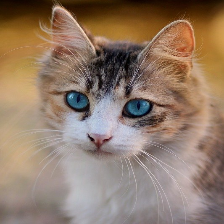

In [55]:
display(Image.fromarray(single_image[0]))

In [56]:
## Normalizing the image 
# Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1.
single_image_norm = tf.keras.utils.normalize(np.asfarray(single_image))

In [57]:
# Shape of the new image list list (first number is the amount of images in this list -> so one :D )
single_image_norm.shape

(1, 224, 224, 3)

In [58]:
# Hot econded categorical given clases 
le.classes_

array(['airplane', 'car', 'cat', 'motorbike', 'person'], dtype=object)

In [59]:
# Predict a single image) by letting the correct neuron fire (here it should be the one at position 3 or index position 2 
# according to the labelencoded list above)
new_model(single_image_norm)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[0., 0., 1., 0., 0.]], dtype=float32)>

In [60]:
# Answer at index number 2 
le.inverse_transform([2])

array(['cat'], dtype=object)